## Setup

In [1]:
from pathlib import Path
import sys

In [2]:
# Add src to path
sys.path.insert(0, str(Path('../src').absolute()))

In [3]:
from env_embeddings.rf_analysis import (
    load_source_data,
    analyze_source,
    create_comparison_table,
    print_summary,
)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

## Load Data Sources

In [6]:
# Define data sources (GOLD and NMDC first, NCBI later)
SOURCES = {
    'GOLD': Path('../data/gold_flattened_biosamples_for_env_embeddings_202510061108_complete.csv'),
    'NMDC': Path('../data/nmdc_flattened_biosample_for_env_embeddings_202510061052_complete.csv'),
    'NCBI-partial': Path('../data/ncbi_flattened_biosamples_for_env_embeddings_202510061108_normalized_complete.csv'),
}

In [7]:
# Load all data WITHOUT deduplication first (more efficient)
datasets_no_dedup = {}
for source_name, file_path in SOURCES.items():
    df = load_source_data(file_path, source_name, deduplicate=False)
    if df is not None:
        datasets_no_dedup[source_name] = df


Loading GOLD
  Loaded: 10,401 rows
  Complete data: 10,401 rows
  Valid embeddings: 10,401 rows

  ENVO scale class counts:
    env_broad_scale     :   40 classes
    env_local_scale     :  139 classes
    env_medium          :   78 classes

Loading NMDC
  Loaded: 8,121 rows
  Complete data: 8,121 rows
  Valid embeddings: 8,121 rows

  ENVO scale class counts:
    env_broad_scale     :   19 classes
    env_local_scale     :   51 classes
    env_medium          :   30 classes

Loading NCBI-partial
  Loaded: 382,955 rows
  Complete data: 382,955 rows
  Valid embeddings: 382,955 rows

  ENVO scale class counts:
    env_broad_scale     :  570 classes
    env_local_scale     :  829 classes
    env_medium          :  562 classes


In [8]:
# Create deduplicated versions from loaded data (in-memory, no re-reading CSV)
datasets_dedup = {}
for source_name, df in datasets_no_dedup.items():
    print(f"\nDeduplicating {source_name}...")
    initial_count = len(df)
    df_dedup = df.drop_duplicates(
        subset=[
            "latitude",
            "longitude",
            "collection_date",
            "env_broad_scale",
            "env_local_scale",
            "env_medium",
        ],
        keep="first",
    ).copy()
    removed = initial_count - len(df_dedup)
    pct_removed = removed / initial_count * 100
    print(f"  {len(df_dedup):,} rows (removed {removed:,} = {pct_removed:.1f}%)")
    datasets_dedup[source_name] = df_dedup


Deduplicating GOLD...
  4,198 rows (removed 6,203 = 59.6%)

Deduplicating NMDC...
  4,646 rows (removed 3,475 = 42.8%)

Deduplicating NCBI-partial...
  73,197 rows (removed 309,758 = 80.9%)


# Remove NCBI from no-dedup version (too large to train on 382K rows)
if 'NCBI-partial' in datasets_no_dedup:
    print("\nRemoving NCBI-partial from non-dedup version (too large)")
    del datasets_no_dedup['NCBI-partial']

In [9]:
# Load non-deduplicated data for comparison (skip NCBI - too large)
datasets_no_dedup = {}
for source_name, file_path in SOURCES.items():
    if source_name == 'NCBI-partial':
        print(f"\nSkipping {source_name} for non-dedup version (too large)")
        continue
    df = load_source_data(file_path, source_name, deduplicate=False)
    if df is not None:
        datasets_no_dedup[source_name] = df


Loading GOLD
  Loaded: 10,401 rows
  Complete data: 10,401 rows
  Valid embeddings: 10,401 rows

  ENVO scale class counts:
    env_broad_scale     :   40 classes
    env_local_scale     :  139 classes
    env_medium          :   78 classes

Loading NMDC
  Loaded: 8,121 rows
  Complete data: 8,121 rows
  Valid embeddings: 8,121 rows

  ENVO scale class counts:
    env_broad_scale     :   19 classes
    env_local_scale     :   51 classes
    env_medium          :   30 classes

Skipping NCBI-partial for non-dedup version (too large)


In [10]:
# Train models for all sources (deduplicated)
all_results = {}
for source_name, df in datasets_dedup.items():
    all_results[source_name] = analyze_source(df, source_name)


------------------------------------------------------------
Training models: GOLD
------------------------------------------------------------

  env_broad_scale...
    Filtered: removed 14 rare classes (29 samples with <5 per class)
    Removed classes (14):
      - ENVO:01001830: 4 samples
      - ENVO:01000216: 4 samples
      - ENVO:01000030: 3 samples
      - ENVO:01000208: 3 samples
      - ENVO:01001838: 2 samples
      - ENVO:01000048: 2 samples
      - ENVO:01001836: 2 samples
      - ENVO:01001831: 2 samples
      - ENVO:01000247: 2 samples
      - ENVO:01000127: 1 samples
      ... and 4 more


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


    Classes:  26 | Test acc: 0.826 | CV: 0.837±0.020 | Overfit: +0.086

  env_local_scale...
    Filtered: removed 63 rare classes (120 samples with <5 per class)
    Removed classes (63):
      - ENVO:00000058: 4 samples
      - ENVO:00000533: 4 samples
      - ENVO:00000309: 4 samples
      - ENVO:00000150: 4 samples
      - ENVO:00000248: 4 samples
      - ENVO:00000444: 4 samples
      - ENVO:00001997: 4 samples
      - ENVO:01000159: 4 samples
      - ENVO:00000014: 4 samples
      - ENVO:00000055: 4 samples
      ... and 53 more


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


    Classes:  76 | Test acc: 0.775 | CV: 0.748±0.013 | Overfit: +0.127

  env_medium...
    Filtered: removed 29 rare classes (51 samples with <5 per class)
    Removed classes (29):
      - ENVO:00001995: 4 samples
      - ENVO:01000358: 4 samples
      - ENVO:01001206: 4 samples
      - ENVO:00005754: 3 samples
      - ENVO:00002263: 3 samples
      - ENVO:01000134: 3 samples
      - ENVO:00005741: 2 samples
      - ENVO:01001185: 2 samples
      - ENVO:00005742: 2 samples
      - ENVO:00002258: 2 samples
      ... and 19 more


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


    Classes:  49 | Test acc: 0.747 | CV: 0.728±0.014 | Overfit: +0.120

------------------------------------------------------------
Training models: NMDC
------------------------------------------------------------

  env_broad_scale...
    Filtered: removed 7 rare classes (15 samples with <5 per class)
    Removed classes (7):
      - ENVO:01000174: 4 samples
      - ENVO:01000215: 3 samples
      - ENVO:01000189: 2 samples
      - ENVO:01000196: 2 samples
      - ENVO:01000216: 2 samples
      - ENVO:01000247: 1 samples
      - ENVO:01000049: 1 samples


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


    Classes:  12 | Test acc: 0.933 | CV: 0.929±0.010 | Overfit: +0.024

  env_local_scale...
    Filtered: removed 15 rare classes (28 samples with <5 per class)
    Removed classes (15):
      - ENVO:00002130: 4 samples
      - ENVO:00002132: 3 samples
      - ENVO:03600018: 2 samples
      - ENVO:00000083: 2 samples
      - ENVO:00000182: 2 samples
      - ENVO:00000444: 2 samples
      - ENVO:00000086: 2 samples
      - ENVO:03600011: 2 samples
      - ENVO:00000305: 2 samples
      - ENVO:00000516: 2 samples
      ... and 5 more


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


    Classes:  36 | Test acc: 0.843 | CV: 0.855±0.009 | Overfit: +0.096

  env_medium...
    Filtered: removed 11 rare classes (21 samples with <5 per class)
    Removed classes (11):
      - ENVO:00005761: 4 samples
      - ENVO:03605002: 3 samples
      - ENVO:00005750: 3 samples
      - ENVO:00002275: 2 samples
      - ENVO:00005781: 2 samples
      - ENVO:03605003: 2 samples
      - ENVO:00005760: 1 samples
      - ENVO:00005773: 1 samples
      - ENVO:01000155: 1 samples
      - ENVO:00005801: 1 samples
      ... and 1 more


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


    Classes:  19 | Test acc: 0.824 | CV: 0.861±0.008 | Overfit: +0.092

------------------------------------------------------------
Training models: NCBI-partial
------------------------------------------------------------

  env_broad_scale...
    Filtered: removed 189 rare classes (392 samples with <5 per class)
    Removed classes (189):
      - ENVO:00005749: 4 samples
      - ENVO:01000604: 4 samples
      - ENVO:01000906: 4 samples
      - ENVO:01000390: 4 samples
      - ENVO:00000303: 4 samples
      - ENVO:00000192: 4 samples
      - ENVO:00000402: 4 samples
      - ENVO:00002272: 4 samples
      - ENVO:01000756: 4 samples
      - ENVO:01000213: 4 samples
      ... and 179 more


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


    Classes: 381 | Test acc: 0.578 | CV: 0.582±0.004 | Overfit: +0.046

  env_local_scale...
    Filtered: removed 279 rare classes (570 samples with <5 per class)
    Removed classes (279):
      - ENVO:00000393: 4 samples
      - ENVO:01000189: 4 samples
      - ENVO:01001289: 4 samples
      - ENVO:03600071: 4 samples
      - ENVO:01001243: 4 samples
      - ENVO:01000857: 4 samples
      - ENVO:00000369: 4 samples
      - ENVO:01000373: 4 samples
      - ENVO:02000047: 4 samples
      - ENVO:01001226: 4 samples
      ... and 269 more


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


    Classes: 550 | Test acc: 0.574 | CV: 0.577±0.010 | Overfit: +0.056

  env_medium...
    Filtered: removed 220 rare classes (399 samples with <5 per class)
    Removed classes (220):
      - ENVO:00005747: 4 samples
      - ENVO:00000223: 4 samples
      - ENVO:00000101: 4 samples
      - ENVO:01000549: 4 samples
      - ENVO:00000382: 4 samples
      - ENVO:00005777: 4 samples
      - ENVO:01000022: 4 samples
      - ENVO:01000049: 4 samples
      - ENVO:01000034: 4 samples
      - ENVO:02000051: 4 samples
      ... and 210 more


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


    Classes: 342 | Test acc: 0.544 | CV: 0.545±0.005 | Overfit: +0.028


## Results Summary

In [11]:
# Create comparison table
comparison_df = create_comparison_table(all_results)

In [12]:
print("\nDetailed Results:")
print(comparison_df.to_string(index=False))


Detailed Results:
      Source       Scale  Classes  Samples  Test_Acc  CV_Mean   CV_Std  Overfitting
        GOLD broad_scale       26     4169  0.826139 0.836882 0.009827     0.086005
        GOLD local_scale       76     4078  0.774510 0.747700 0.006497     0.127391
        GOLD      medium       49     4147  0.746988 0.728370 0.006968     0.120362
        NMDC broad_scale       12     4631  0.933118 0.929268 0.004996     0.024496
        NMDC local_scale       36     4618  0.843074 0.854631 0.004279     0.095746
        NMDC      medium       19     4625  0.823784 0.861351 0.004152     0.091892
NCBI-partial broad_scale      381    72805  0.577502 0.582326 0.002064     0.046288
NCBI-partial local_scale      550    72627  0.574074 0.576840 0.004931     0.055554
NCBI-partial      medium      342    72798  0.544299 0.545091 0.002699     0.027698


In [13]:
# Print actionable summary
print_summary(comparison_df)



SUMMARY: Random Forest ENVO Prediction Performance

Overall mean test accuracy: 0.738

Best:  NMDC   broad_scale  = 0.933
Worst: NCBI-partial medium       = 0.544

Performance by source:
  GOLD  : 0.783 avg, +0.111 overfit
  NMDC  : 0.867 avg, +0.071 overfit
  NCBI-partial: 0.565 avg, +0.043 overfit

Performance by scale:
  broad_scale : 0.779 avg, 140 avg classes
  local_scale : 0.731 avg, 221 avg classes
  medium      : 0.705 avg, 137 avg classes

ACTIONABLE INSIGHTS

~ Satellite embeddings have MODERATE predictive power
⚠️  Moderate overfitting (max=0.127)

⚠️  Large variation across sources (std=0.156) - data quality differs


## Visualization: Test Accuracy by Scale

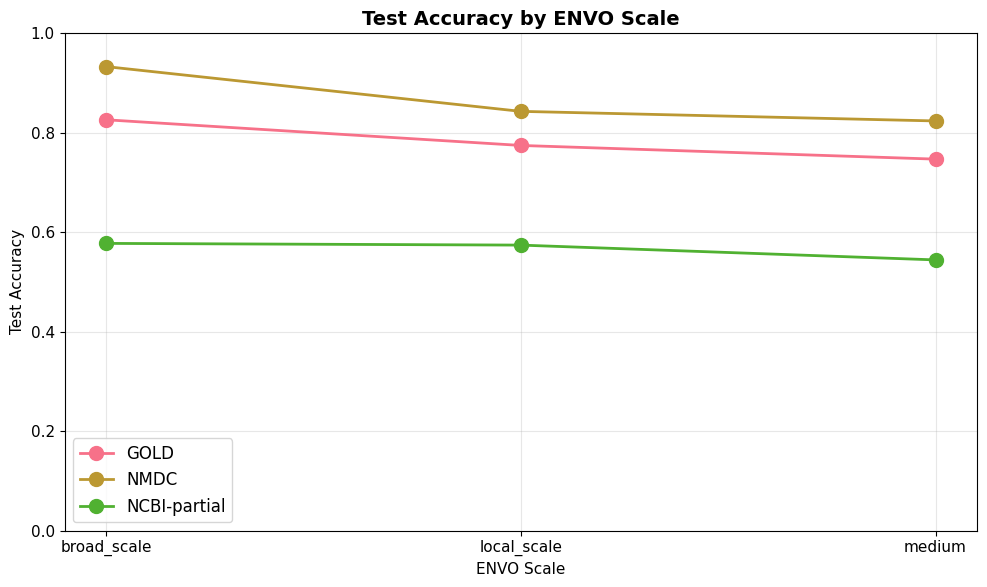

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))

for source in comparison_df['Source'].unique():
    data = comparison_df[comparison_df['Source'] == source]
    ax.plot(data['Scale'], data['Test_Acc'],
            marker='o', linewidth=2, markersize=10, label=source)

ax.set_title('Test Accuracy by ENVO Scale', fontsize=14, fontweight='bold')
ax.set_xlabel('ENVO Scale')
ax.set_ylabel('Test Accuracy')
ax.set_ylim(0, 1.0)
ax.legend(fontsize=12)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Visualization: Average Accuracy by Source

In [15]:
avg_by_source = comparison_df.groupby('Source')['Test_Acc'].mean()

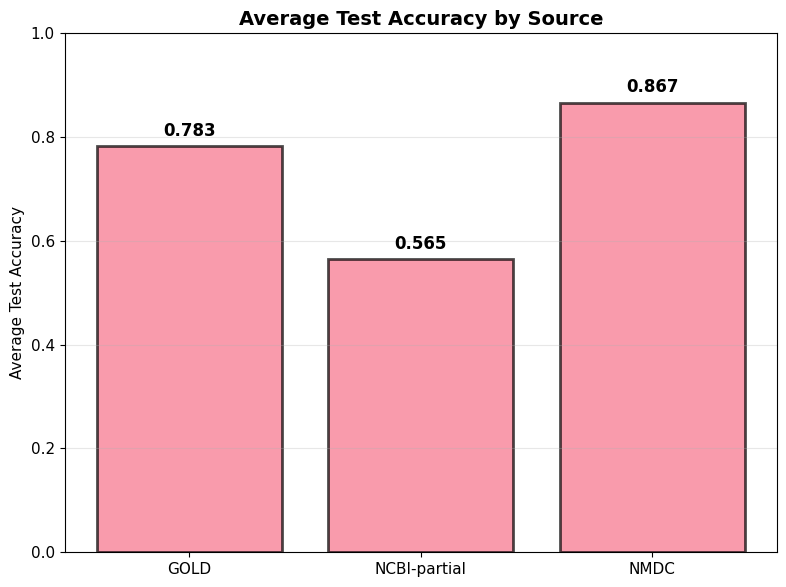

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(avg_by_source.index, avg_by_source.values,
              alpha=0.7, edgecolor='black', linewidth=2)
ax.set_title('Average Test Accuracy by Source', fontsize=14, fontweight='bold')
ax.set_ylabel('Average Test Accuracy')
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{height:.3f}', ha='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

## Visualization: Overfitting Check

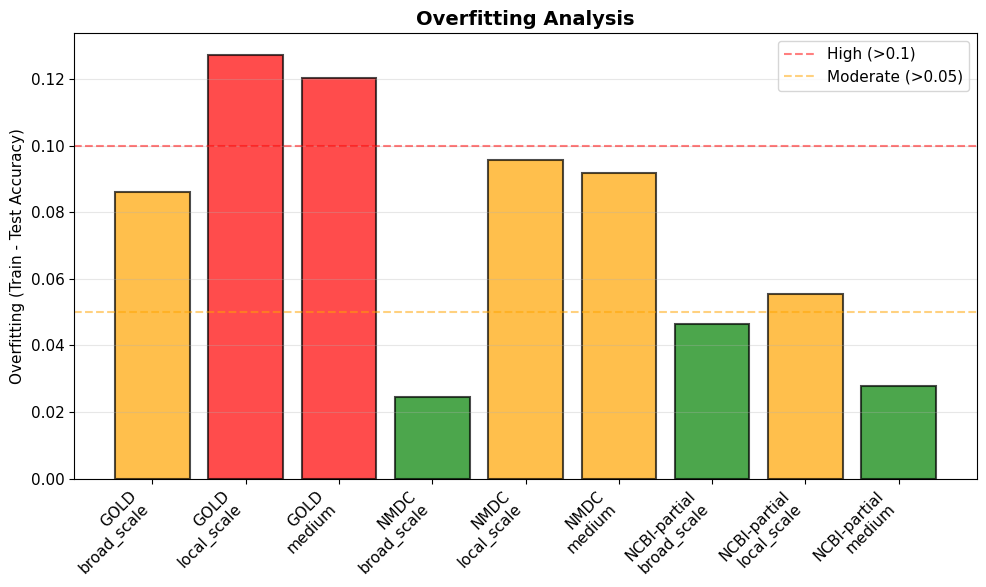

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

# Color bars by overfitting severity
colors = ['red' if x > 0.1 else 'orange' if x > 0.05 else 'green'
          for x in comparison_df['Overfitting'].values]

x_labels = [f"{row['Source']}\n{row['Scale']}"
            for _, row in comparison_df.iterrows()]

bars = ax.bar(range(len(comparison_df)), comparison_df['Overfitting'].values,
              color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

ax.set_xticks(range(len(comparison_df)))
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.set_ylabel('Overfitting (Train - Test Accuracy)')
ax.set_title('Overfitting Analysis', fontsize=14, fontweight='bold')
ax.axhline(y=0.1, color='red', linestyle='--', alpha=0.5, label='High (>0.1)')
ax.axhline(y=0.05, color='orange', linestyle='--', alpha=0.5, label='Moderate (>0.05)')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Save Results

In [18]:
output_dir = Path('../results/rf_multi_source')
output_dir.mkdir(parents=True, exist_ok=True)

In [19]:
output_file = output_dir / 'comparison_results.csv'
comparison_df.to_csv(output_file, index=False)
print(f"Results saved to: {output_file}")

Results saved to: ../results/rf_multi_source/comparison_results.csv


In [20]:
# Import per-class performance function
from env_embeddings.rf_analysis import print_class_performance

In [21]:
# Show per-class performance for each source
for source_name in all_results:
    print_class_performance(all_results[source_name], source_name)



PER-CLASS PERFORMANCE: GOLD


env_broad_scale:
  Total classes: 22
  Macro avg F1: 0.663
  Weighted avg F1: 0.804

  High performers (F1 > 0.9): 6 classes
    ENVO:01000176: F1=1.000, support=9
    ENVO:01000035: F1=1.000, support=9
    ENVO:01000249: F1=1.000, support=2
    ENVO:01000252: F1=0.955, support=124
    ENVO:00000447: F1=0.944, support=47

  Poor performers (F1 < 0.3): 4 classes
    ENVO:01000196: F1=0.250, support=7
    ENVO:01000219: F1=0.111, support=31
    ENVO:01000221: F1=0.000, support=6
    ENVO:01001834: F1=0.000, support=3

  ⚠️  Classes with 0% F1 (completely failed): 2
      These are likely rare classes that need more samples or parent grouping

env_local_scale:
  Total classes: 73
  Macro avg F1: 0.644
  Weighted avg F1: 0.756

  High performers (F1 > 0.9): 22 classes
    ENVO:00000033: F1=1.000, support=1
    ENVO:00000039: F1=1.000, support=5
    ENVO:00000469: F1=1.000, support=1
    ENVO:00000266: F1=1.000, support=3
    ENVO:01000044: F1=1.000, support=

## Deduplication Impact Analysis

In [22]:
# Train models on non-deduplicated data
all_results_no_dedup = {}
for source_name, df in datasets_no_dedup.items():
    all_results_no_dedup[source_name] = analyze_source(df, f"{source_name}-NoDedup")


------------------------------------------------------------
Training models: GOLD-NoDedup
------------------------------------------------------------

  env_broad_scale...
    Filtered: removed 10 rare classes (24 samples with <5 per class)
    Removed classes (10):
      - ENVO:01000247: 4 samples
      - ENVO:01000216: 4 samples
      - ENVO:01001838: 3 samples
      - ENVO:01001831: 3 samples
      - ENVO:01001836: 3 samples
      - ENVO:01000048: 2 samples
      - ENVO:00000044: 2 samples
      - ENVO:01000127: 1 samples
      - ENVO:01000229: 1 samples
      - ENVO:01001835: 1 samples


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


    Classes:  30 | Test acc: 0.911 | CV: 0.907±0.011 | Overfit: +0.018

  env_local_scale...
    Filtered: removed 38 rare classes (86 samples with <5 per class)
    Removed classes (38):
      - ENVO:00002000: 4 samples
      - ENVO:00000305: 4 samples
      - ENVO:00000078: 4 samples
      - ENVO:00000055: 4 samples
      - ENVO:00002168: 4 samples
      - ENVO:00000195: 4 samples
      - ENVO:04000010: 3 samples
      - ENVO:00000083: 3 samples
      - ENVO:01000687: 3 samples
      - ENVO:00000081: 3 samples
      ... and 28 more


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


    Classes: 101 | Test acc: 0.830 | CV: 0.821±0.027 | Overfit: +0.036

  env_medium...
    Filtered: removed 15 rare classes (24 samples with <5 per class)
    Removed classes (15):
      - ENVO:00002263: 3 samples
      - ENVO:03000038: 3 samples
      - ENVO:00002243: 2 samples
      - ENVO:01001651: 2 samples
      - ENVO:02000140: 2 samples
      - ENVO:00002258: 2 samples
      - ENVO:00005741: 2 samples
      - ENVO:01000231: 1 samples
      - ENVO:01000001: 1 samples
      - ENVO:01000964: 1 samples
      ... and 5 more


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


    Classes:  63 | Test acc: 0.826 | CV: 0.816±0.009 | Overfit: +0.018

------------------------------------------------------------
Training models: NMDC-NoDedup
------------------------------------------------------------

  env_broad_scale...
    Filtered: removed 3 rare classes (7 samples with <5 per class)
    Removed classes (3):
      - ENVO:01000189: 4 samples
      - ENVO:01000247: 2 samples
      - ENVO:01000049: 1 samples


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


    Classes:  16 | Test acc: 0.961 | CV: 0.961±0.009 | Overfit: +0.016

  env_local_scale...
    Filtered: removed 9 rare classes (30 samples with <5 per class)
    Removed classes (9):
      - ENVO:00002130: 4 samples
      - ENVO:00000182: 4 samples
      - ENVO:00000305: 4 samples
      - ENVO:00000083: 4 samples
      - ENVO:00000086: 4 samples
      - ENVO:00000444: 4 samples
      - ENVO:00002132: 3 samples
      - ENVO:00000128: 2 samples
      - ENVO:00000426: 1 samples


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


    Classes:  42 | Test acc: 0.882 | CV: 0.888±0.014 | Overfit: +0.047

  env_medium...
    Filtered: removed 3 rare classes (5 samples with <5 per class)
    Removed classes (3):
      - ENVO:00005760: 2 samples
      - ENVO:00005773: 2 samples
      - ENVO:01000155: 1 samples
    Classes:  27 | Test acc: 0.890 | CV: 0.895±0.012 | Overfit: +0.039


In [23]:
# Import dedup comparison function
from env_embeddings.rf_analysis import create_dedup_comparison_table

In [24]:
# Create comparison table
dedup_comparison = create_dedup_comparison_table(all_results, all_results_no_dedup)

In [25]:
# Display comparison
print("\nDeduplication Impact Comparison:")
print(dedup_comparison.to_string(index=False))


Deduplication Impact Comparison:
Source       Scale  Dedup_Acc  NoDedup_Acc  Acc_Delta  Dedup_Overfit  NoDedup_Overfit  Overfit_Delta  Dedup_Samples  NoDedup_Samples
  GOLD broad_scale   0.826139     0.911368  -0.085229       0.086005         0.018038       0.067967           4169            10377
  GOLD local_scale   0.774510     0.830344  -0.055834       0.127391         0.035870       0.091521           4078            10315
  GOLD      medium   0.746988     0.826108  -0.079120       0.120362         0.017646       0.102716           4147            10377
  NMDC broad_scale   0.933118     0.960567  -0.027449       0.024496         0.015554       0.008942           4631             8114
  NMDC local_scale   0.843074     0.882026  -0.038952       0.095746         0.047362       0.048384           4618             8091
  NMDC      medium   0.823784     0.890394  -0.066610       0.091892         0.039212       0.052680           4625             8116


## Visualization: Deduplication Impact

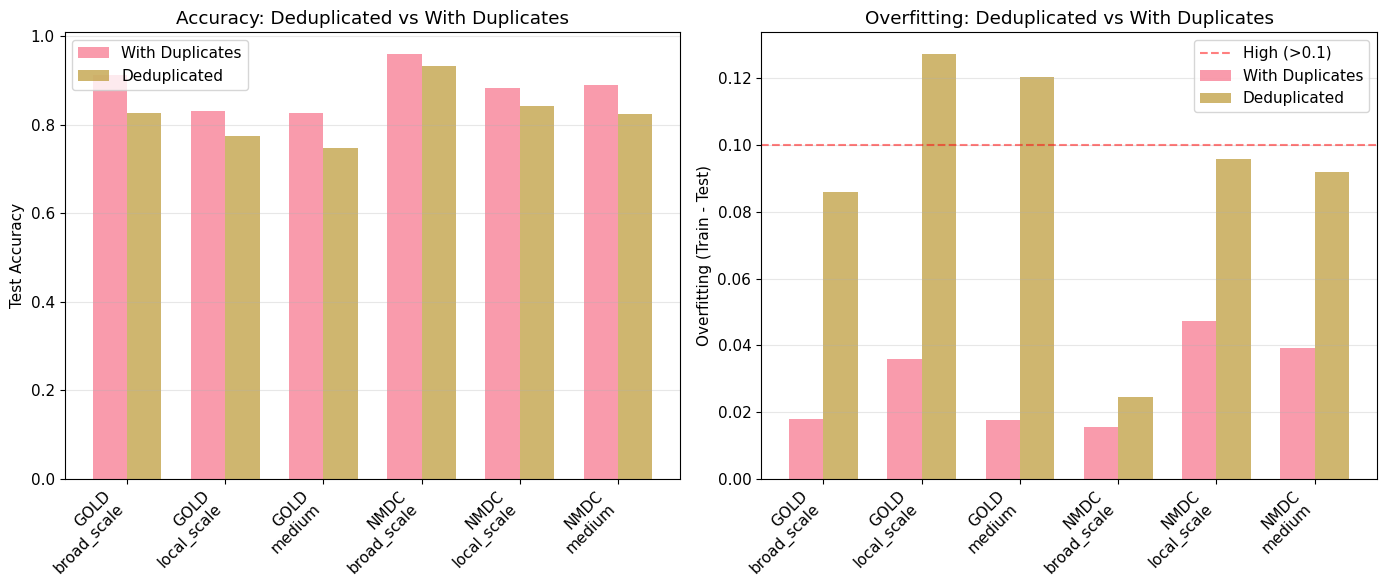

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy comparison
x = range(len(dedup_comparison))
width = 0.35
ax1.bar([i - width/2 for i in x], dedup_comparison['NoDedup_Acc'],
        width, label='With Duplicates', alpha=0.7)
ax1.bar([i + width/2 for i in x], dedup_comparison['Dedup_Acc'],
        width, label='Deduplicated', alpha=0.7)
ax1.set_ylabel('Test Accuracy')
ax1.set_title('Accuracy: Deduplicated vs With Duplicates')
ax1.set_xticks(x)
ax1.set_xticklabels([f"{row['Source']}\n{row['Scale']}"
                      for _, row in dedup_comparison.iterrows()], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Overfitting comparison
ax2.bar([i - width/2 for i in x], dedup_comparison['NoDedup_Overfit'],
        width, label='With Duplicates', alpha=0.7)
ax2.bar([i + width/2 for i in x], dedup_comparison['Dedup_Overfit'],
        width, label='Deduplicated', alpha=0.7)
ax2.set_ylabel('Overfitting (Train - Test)')
ax2.set_title('Overfitting: Deduplicated vs With Duplicates')
ax2.set_xticks(x)
ax2.set_xticklabels([f"{row['Source']}\n{row['Scale']}"
                      for _, row in dedup_comparison.iterrows()], rotation=45, ha='right')
ax2.axhline(y=0.1, color='red', linestyle='--', alpha=0.5, label='High (>0.1)')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Per-Class Performance Analysis